In [1]:
import sys
import random
import numpy as np
import pdb
import math
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
#actions
_stay = 0
_right = 1
_left = 2
_up = 3
_down = 4


# other global parameters

episode = 2500
end_timestep = 50

alpha  = 0.1
alpha_decay = 0.9999

epsilon = 0.2
epsilon_decay = 0.9999


gamma = 0.9

num_agents = 4
num_POIs = 4
poi_value = 1

ROW=10
COL=10

x_axis=np.arange(0,episode,1)
SPEED=1

In [3]:
class GridAgent(object):
    def __init__(self, agent_id, alpha, alpha_decay, epsilon, epsilon_decay, gamma, row=10, col=10):
        self.row, self.col = row, col
        self.agent_id=agent_id
        self.last_action = 0
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.alpha=alpha
        self.alpha_decay=alpha_decay
        self.gamma=gamma
        self.x=0
        self.y=0
        self.last_x=0
        self.last_y=0
        self.qtable=[]
        self._init_qtable()
        self.previous_potential=0
        self.current_potential=0
        self._init_pos()
        self.local_rewards=[]
    
        
    
        
        
    def _init_qtable(self):
        '''
            each section has 5 actions
            0 : stay
            1 : right
            2 : left
            3 : up
            4 : down
        '''
        self.qtable = [[[-1 for i in range(5)] for k in range(self.row)] for j in range(self.col)]
        
    def _init_pos(self):
        self.x=int(self.row/2.0)
        self.y=int(self.col/2.0)
    
        if self.agent_id == 0:
            self.x += SPEED
            self.y += SPEED;
        elif self.agent_id == 1:
            self.x -= SPEED
            self.y += SPEED
        elif self.agent_id == 2:
            self.x -= SPEED
            self.y -= SPEED
        elif self.agent_id == 3:
            self.x += SPEED
            self.y -= SPEED
            
        
        
        
    def restart(self):
        self._init_pos()
        self.last_action = 0
        self.last_x=0
        self.last_y=0
        
        self.previous_potential=0
        self.current_potential=0
        self.local_rewards=[]
        
        
        
        
        
    def select_action(self):
        """
        Select an action using epsilon-greedy algorithm, and filter out illegal actions
        """
        self.last_x=self.x
        self.last_y=self.y
        self._update_parameters()
        action = self._e_greedy()

        self.last_action = action 
        
        return action
    
    def do_action(self):
        """
        Move agents to new position/state
        """
        
        
        if self.last_action==_left:
            self.x-=SPEED
        elif self.last_action==_right:
            self.x+=SPEED   
        elif self.last_action==_up:
            self.y+=SPEED
        elif self.last_action==_down:
            self.y-=SPEED
            
        # correct illegal actions
        if self.x<0:
            self.x=0
            
        elif self.x>=self.row:
            self.x=self.row-SPEED
        if self.y<0:
            self.y=0
        
        elif self.y>=self.col:
            self.y=self.col-SPEED
        
    
    def _e_greedy(self):
        """
        Epsilon-greedy algorithm
        """
        if random.random() <= self.epsilon:
            action = self.random_select_action()
        else:
            action = self.greedy_select_action()

        return action
    
    def greedy_select_action(self):
        """
        Select max q-value. First get the max value and get the action. If there are 2 or 3 max values, just randomly choose one
        """
        
        max_reward=max(self.qtable[self.x][self.y])
        max_index=[i for i,x in enumerate(self.qtable[self.x][self.y]) if x==max_reward] 
        if len(max_index)>1:
            max_action=random.choice(max_index)
        else:
            max_action=max_index[0]
        

        return max_action 

    def random_select_action(self):
        """
        Select action randomly
        """
        action = random.randint(0,4)
                
        return action

    def _update_q_table(self, reward):
        """
        Update q-table
        """
        
        self.qtable[self.last_x][self.last_y][self.last_action] = self.alpha * reward + (1.0 - self.alpha)*self.qtable[self.last_x][self.last_y][self.last_action]+self.alpha*self.gamma*max(self.qtable[self.x][self.y])
        #self.qtable[self.last_position][self.last_action] = round(self.qtable[self.last_position][self.last_action], 3)
    
    def _update_final_qtable(self, reward):
        """
        Update final q table
        """
        
        self.qtable[self.x][self.y][self.last_action] = self.alpha * reward + (1.0 - self.alpha)*self.qtable[self.x][self.y][self.last_action]
        #self.qtable[self.position][self.last_action] = round(self.qtable[self.position][self.last_action], 3)
    def _update_parameters(self):
        """
        Update epsilon and alpha (learning rate)
        """
        self.epsilon=self.epsilon*self.epsilon_decay
        self.alpha=self.alpha*self.alpha_decay
        
    def cal_manhattan_dist(self, poi_x, poi_y):
        dx=math.fabs(self.x-poi_x)
        dy=math.fabs(self.y-poi_y)
        distance=dx+dy
        return distance
    
    def get_one_reward(self, poi_value, poi_x, poi_y):
        l_reward=0
        distance=self.cal_manhattan_dist(poi_x, poi_y)
        if distance<=2:
            l_reward=poi_value
        elif distance>2 and distance<=ROW:
            l_reward=poi_value/(distance*distance)
        else:
            l_reward=0
            
        return l_reward


In [4]:
class Pois:
    def __init__(self, poi_id, random_poi):
        self.x=0
        self.y=0
        self.value=1
        self.poi_id=poi_id
        self._init_poi_pos()
        if self.poi_id == random_poi:
            self.value=5
        
            
    def _init_poi_pos(self):
        if self.poi_id==0:
            self.x=1
            self.y=1
        elif self.poi_id==1:
            self.x=ROW-2
            self.y=1
        elif self.poi_id==2:
            self.x=ROW-2
            self.y=COL-2
        elif self.poi_id==3:
            self.x=1
            self.y=COL-2

In [5]:
class GridWorldDomain():
    agents = []
    pois=[]
    def __init__(self,random_id):
        self._init_agents()
        self.sum_global=0
        self.global_rewards=[]
        self.random_id=random_id
        
        self._init_pois()

    def _init_agents(self):
        """ initialize agents
            all agent select action by epsilon greedy .
        """
        self.agents = [GridAgent(agent_id=i, alpha=alpha, alpha_decay=alpha_decay, epsilon=epsilon, epsilon_decay=epsilon_decay, gamma=gamma, row=ROW, col=COL) for i in range(0, 4)]
    
    def _init_pois(self):
        #big_poi=random.randint(0,3)
        self.pois= [Pois(poi_id=i, random_poi=self.random_id) for i in range(0, 4)]
        
        
        #self.pois[big_poi].value=5
    
        
    def get_local_reward(self, agent_id):
        #local_reward=[]
        agent=self.agents[agent_id]
        agent.local_rewards=[]
        for i, poi in enumerate(self.pois):
            agent.local_rewards.append(agent.get_one_reward(poi.value, poi.x, poi.y))
            
        return sum(agent.local_rewards)
        
    
        
        
        

In [6]:
#
def local_reward_simulation(random_id):
    """
    Local rewards alone
    """
    gwd=GridWorldDomain(random_id)
    global_reward_list=[]
    
    
    for e in range(episode):
        gwd.sum_global=0
        for t in range(end_timestep):
            gwd.global_rewards=[]
            for agent in gwd.agents:
                action=agent.select_action()
                agent.do_action()
                l_reward=gwd.get_local_reward(agent.agent_id)
                gwd.global_rewards.append(agent.local_rewards)
                agent._update_q_table(l_reward)
                
            
            all_poi_observations=np.array(gwd.global_rewards).transpose()   
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])
            gwd.sum_global+=single_global
            
                
        for agent in gwd.agents:
            action=agent.select_action()
            agent._update_final_qtable(0)
            agent.restart()
                
                
        global_reward_list.append(gwd.sum_global)
        
    
    return global_reward_list


def local_reward_manual_simulation(random_id):
    """
    Local+ManualPBRS rewards alone
    """
    gwd5=GridWorldDomain(random_id)
    global_reward_list5=[]
    
    
    for e in range(episode):
        gwd5.sum_global=0
        for t in range(end_timestep):
            gwd5.global_rewards=[]
            for agent in gwd5.agents:
                #agent.previous_potential=agent.cal_manhattan_dist(ROW/2, COL/2)
                action=agent.select_action()
                agent.do_action()
                agent.current_potential=agent.cal_manhattan_dist(ROW/2, COL/2)
                l_reward=gwd5.get_local_reward(agent.agent_id)
                gwd5.global_rewards.append(agent.local_rewards)
                
                shaped_r=l_reward+agent.gamma*agent.current_potential-agent.previous_potential
                agent._update_q_table(shaped_r)
                agent.previous_potential=agent.current_potential
                
            
            all_poi_observations=np.array(gwd5.global_rewards).transpose()   
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])
            gwd5.sum_global+=single_global
            
                
        for agent in gwd5.agents:
            action=agent.select_action()
            shaped_r=0-agent.current_potential
            agent._update_final_qtable(shaped_r)
            agent.restart()
                
                
        global_reward_list5.append(gwd5.sum_global)
        
    
    return global_reward_list5


def global_reward_simulation(random_id):
    """
    global rewards alone
    """
    gwd2=GridWorldDomain(random_id)
    global_reward_list2=[]
    
    for e in range(episode):
        gwd2.sum_global=0
        for t in range(end_timestep):
            gwd2.global_rewards=[]
            
            for agent in gwd2.agents:
                action=agent.select_action()
                agent.do_action()
                l_reward=gwd2.get_local_reward(agent.agent_id)
                gwd2.global_rewards.append(agent.local_rewards)
        
            
            all_poi_observations=np.array(gwd2.global_rewards).transpose()  
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])
            gwd2.sum_global+=single_global
            for agent in gwd2.agents:
                agent._update_q_table(single_global)
            
            
                
        for agent in gwd2.agents:
            action=agent.select_action()
            agent._update_final_qtable(0)
            agent.restart()
                
                
        global_reward_list2.append(gwd2.sum_global)
        
    return global_reward_list2


def global_reward_manual_simulation(random_id):
    """
    Global+ManualPBRS rewards alone
    """
    gwd6=GridWorldDomain(random_id)
    global_reward_list6=[]
    
    
    for e in range(episode):
        gwd6.sum_global=0
        for t in range(end_timestep):
            gwd6.global_rewards=[]
            for agent in gwd6.agents:
                #agent.previous_potential=agent.cal_manhattan_dist(ROW/2, COL/2)
                action=agent.select_action()
                agent.do_action()
                agent.current_potential=agent.cal_manhattan_dist(ROW/2, COL/2)
                l_reward=gwd6.get_local_reward(agent.agent_id)
                gwd6.global_rewards.append(agent.local_rewards)
                #agent._update_q_table(l_reward)
                
                
                
            
            all_poi_observations=np.array(gwd6.global_rewards).transpose()   
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])
            gwd6.sum_global+=single_global
            
            for agent in gwd6.agents:
                shaped_r=single_global+agent.gamma*agent.current_potential-agent.previous_potential
                agent._update_q_table(shaped_r)
                agent.previous_potential=agent.current_potential
                
        for agent in gwd6.agents:
            action=agent.select_action()
            shaped_r=0-agent.previous_potential
            agent._update_final_qtable(shaped_r)
            agent.restart()
                
                
        global_reward_list6.append(gwd6.sum_global)
        
    
    return global_reward_list6


def cap_reward_simulation(random_id):
    """
    CaP rewards alone
    """
    gwd3=GridWorldDomain(random_id)
    global_reward_list3=[]
    
    for e in range(episode):
        gwd3.sum_global=0
        for t in range(end_timestep):
            gwd3.global_rewards=[]
            for agent in gwd3.agents:
                action=agent.select_action()
                agent.do_action()
                l_reward=gwd3.get_local_reward(agent.agent_id)
                gwd3.global_rewards.append(agent.local_rewards)
                
                
            
            all_poi_observations=np.array(gwd3.global_rewards).transpose()    
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])  #single step global rewards
            gwd3.sum_global+=single_global
            
            for agent in gwd3.agents:
                gzmi_local=gwd3.global_rewards.copy()
                gzmi_local=list(gzmi_local)
                del gzmi_local[agent.agent_id]
                gzmi_local=np.array(gzmi_local).transpose()   
                agent.current_potential=max(gzmi_local[0])+max(gzmi_local[1])+max(gzmi_local[2])+max(gzmi_local[3]) 
                shaped_r=single_global+agent.gamma*agent.current_potential-agent.previous_potential
                
                agent._update_q_table(shaped_r)
                agent.previous_potential=agent.current_potential
            
            
                
        for agent in gwd3.agents:
            action=agent.select_action()
            shaped_r=0-agent.previous_potential
            agent._update_final_qtable(shaped_r)
            agent.restart()
                
                
        global_reward_list3.append(gwd3.sum_global)
        
    
    return global_reward_list3


def difference_reward_simulation(random_id):
    """
    difference rewards alone
    """
    gwd4=GridWorldDomain(random_id)
    global_reward_list4=[]
    
    for e in range(episode):
        gwd4.sum_global=0
        for t in range(end_timestep):
            gwd4.global_rewards=[]
            for agent in gwd4.agents:
                action=agent.select_action()
                agent.do_action()
                l_reward=gwd4.get_local_reward(agent.agent_id)
                gwd4.global_rewards.append(agent.local_rewards)
                
            all_poi_observations=np.array(gwd4.global_rewards).transpose() 
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])  #single step global rewards
            gwd4.sum_global+=single_global
            
            for agent in gwd4.agents:
                gzmi_local=gwd4.global_rewards.copy()
                gzmi_local=list(gzmi_local)
                del gzmi_local[agent.agent_id]
                gzmi_local=np.array(gzmi_local).transpose()   
                other_global=max(gzmi_local[0])+max(gzmi_local[1])+max(gzmi_local[2])+max(gzmi_local[3]) 
                
                shaped_r=single_global-other_global
                
                
                agent._update_q_table(shaped_r)
                
            
            
                
        for agent in gwd4.agents:
            action=agent.select_action()
            
            agent._update_final_qtable(0)
            agent.restart()
                
                
        global_reward_list4.append(gwd4.sum_global)
        
    
    return global_reward_list4


def drip_reward_simulation(random_id):
    """
    drip rewards alone
    """
    gwd7=GridWorldDomain(random_id)
    global_reward_list7=[]
    
    for e in range(episode):
        gwd7.sum_global=0
        for t in range(end_timestep):
            gwd7.global_rewards=[]
            for agent in gwd7.agents:
                #agent.previous_potential=agent.cal_manhattan_dist(ROW/2, COL/2)
                action=agent.select_action()
                agent.do_action()
                agent.current_potential=agent.cal_manhattan_dist(ROW/2, COL/2)
                l_reward=gwd7.get_local_reward(agent.agent_id)
                gwd7.global_rewards.append(agent.local_rewards)
                
            all_poi_observations=np.array(gwd7.global_rewards).transpose() 
            single_global=max(all_poi_observations[0])+max(all_poi_observations[1])+max(all_poi_observations[2])+max(all_poi_observations[3])  #single step global rewards
            gwd7.sum_global+=single_global
            
            for agent in gwd7.agents:
                gzmi_local=gwd7.global_rewards.copy()
                gzmi_local=list(gzmi_local)
                del gzmi_local[agent.agent_id]
                gzmi_local=np.array(gzmi_local).transpose()   
                other_global=max(gzmi_local[0])+max(gzmi_local[1])+max(gzmi_local[2])+max(gzmi_local[3]) 
                
                dr=single_global-other_global
                shaped_r=dr+agent.gamma*agent.current_potential-agent.previous_potential
                
                agent._update_q_table(shaped_r)
                agent.previous_potential=agent.current_potential
            
            
                
        for agent in gwd7.agents:
            action=agent.select_action()
            shaped_r=0-agent.current_potential
            agent._update_final_qtable(shaped_r)
            agent.restart()
                
                
        global_reward_list7.append(gwd7.sum_global)
        
    
    return global_reward_list7





In [7]:
list1=[]
list2=[]
list3=[]
list4=[]
list5=[]
list6=[]
list7=[]

for i in range(30):  #run simulation 10 times and get average
    print(i)
    
    big_poi=random.randint(0,3)
    local_array=np.array(local_reward_simulation(big_poi))
    global_array=np.array(global_reward_simulation(big_poi))
    cap_array=np.array(cap_reward_simulation(big_poi))
    d_array=np.array(difference_reward_simulation(big_poi))
    l_m_array=np.array(local_reward_manual_simulation(big_poi))
    g_m_array=np.array(global_reward_manual_simulation(big_poi))
    drip_array=np.array(drip_reward_simulation(big_poi))
    
    list1.append(local_array)
    list2.append(global_array)
    list3.append(cap_array)
    list4.append(d_array)
    list5.append(l_m_array)
    list6.append(g_m_array)
    list7.append(drip_array)
    

list1=np.array(list1)
list2=np.array(list2)
list3=np.array(list3)
list4=np.array(list4)
list5=np.array(list5)
list6=np.array(list6)
list7=np.array(list7)


list1=np.average(list1, axis=0)
list2=np.average(list2, axis=0)
list3=np.average(list3, axis=0)
list4=np.average(list4, axis=0)
list5=np.average(list5, axis=0)
list6=np.average(list6, axis=0)
list7=np.average(list7, axis=0)


0
1
2
3
4
5
6
7
8
9


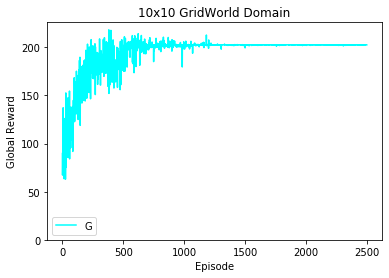

In [8]:

plt.plot(x_axis,list1,color="green", label="L")
plt.plot(x_axis,list2,color="cyan", label="G")
plt.plot(x_axis,list3,color="purple", label="G+CaP")
plt.plot(x_axis,list4,color="blue", label="D")
plt.plot(x_axis,list5,color="orange", label="L+ManualPBRS")
plt.plot(x_axis,list6,color="red", label="G+ManualPBRS")
plt.plot(x_axis,list7,color="black", label="DRiP")

plt.legend()
plt.ylim(ymin=0)
plt.xlabel('Episode')
plt.ylabel('Global Reward')
plt.title('10x10 GridWorld Domain')
plt.savefig('Figure_5_new.png')
plt.show()



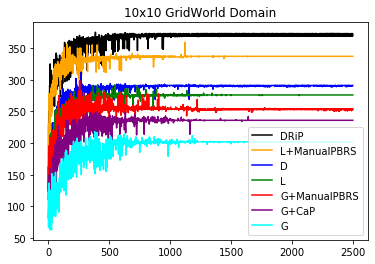

In [10]:
"""
f= open("d_alone.txt","w+")
for i in list4:
     f.write("%d\n" % i)
"""
f= open("g_alone.txt","w+")
for i in list2:
     f.write("%d\n" % i)
import csv
y0=[]
y1=[]
y2=[]
y3=[]
y4=[]
y5=[]
y6=[]
f1= open("d_alone.txt","r")
f2= open("drip.txt","r")
f3= open("l_manualPBRS.txt","r")
f4= open("l_alone.txt","r")
f5= open("g_manualPBRS.txt","r")
f6= open("cap.txt","r")
f7= open("g_alone.txt","r")
plot=csv.reader(f1)
plots=csv.reader(f2)
plots2=csv.reader(f3)
plots4=csv.reader(f4)
plots5=csv.reader(f5)
plots6=csv.reader(f6)
plots7=csv.reader(f7)
for row in plot:
    y0.append(int(row[0]))
for row in plots:
    y1.append(int(row[0]))
for row in plots2:
    y2.append(int(row[0]))
for row in plots4:
    y3.append(int(row[0]))
for row in plots5:
    y4.append(int(row[0]))
for row in plots6:
    y5.append(int(row[0]))
for row in plots7:
    y6.append(int(row[0]))

plt.plot(x_axis, y1, label="DRiP", color="black")
plt.plot(x_axis, y2, label="L+ManualPBRS", color="orange")
plt.plot(x_axis, y0, label="D", color="blue")
plt.plot(x_axis, y3, label="L", color="green")
plt.plot(x_axis, y4, label="G+ManualPBRS", color="red")
plt.plot(x_axis, y5, label="G+CaP", color="purple")
plt.plot(x_axis, y6, label="G", color="cyan")
plt.legend()
plt.title('10x10 GridWorld Domain')
plt.savefig('Figure_5.png')
plt.show()